 

(f_rs_band_math)=

---------------
```{admonition} Learning Objectives
  - Learn about basic principals of band math
  - Calculate common indicies like NDVI, EVI etc
```
```{admonition} Review
* [Raster Data ](c_rasters.md)
* [Opening Remotely Sensed Data](f_rs_io.md)
* [Sensor specific configurations](f_rs_config.md)
```
--------------


# Band Math & Vegetation Indices

## Band Math Basics
Band math is a way to combine bands of remotely sensed data to create new bands that highlight certain features. Calculations can be as simple as adding or subtracting bands, or more complex like calculating vegetation indices. Each operation is done on a per-pixel basis, so the output will have the same spatial extent and resolution as the input.

Here is a visual example of a band math operation combinine three bands of data `b1`, `b2`, and `b3` to create a new single output. 

```{image} ../_static/f_rs/bandmath.gif
:alt: a visual example of a band math operation combinine three bands of data b1, b2, and b3 to create a new single output.
Band math example
```

## Band Math in Geowombat

Geowombat has a number of functions to perform band math operations.

### Arithmetic operations
We can perform basic arithmetic operations on bands like addition, subtraction, multiplication, and division. For example, we can combine the red and green bands to create a new band that highlights vegetation.

In [1]:
import geowombat as gw
from geowombat.data import rgbn
import matplotlib.pyplot as plt


Calculate a new band adding the `red` and `nir` bands, returning an `Xarray.DataArray`.

<xarray.DataArray (y: 403, x: 515)>
dask.array<add, shape=(403, 515), dtype=uint8, chunksize=(64, 64), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 7.93e+05 7.93e+05 7.93e+05 ... 7.956e+05 7.956e+05
  * y        (y) float64 2.05e+06 2.05e+06 2.05e+06 ... 2.048e+06 2.048e+06


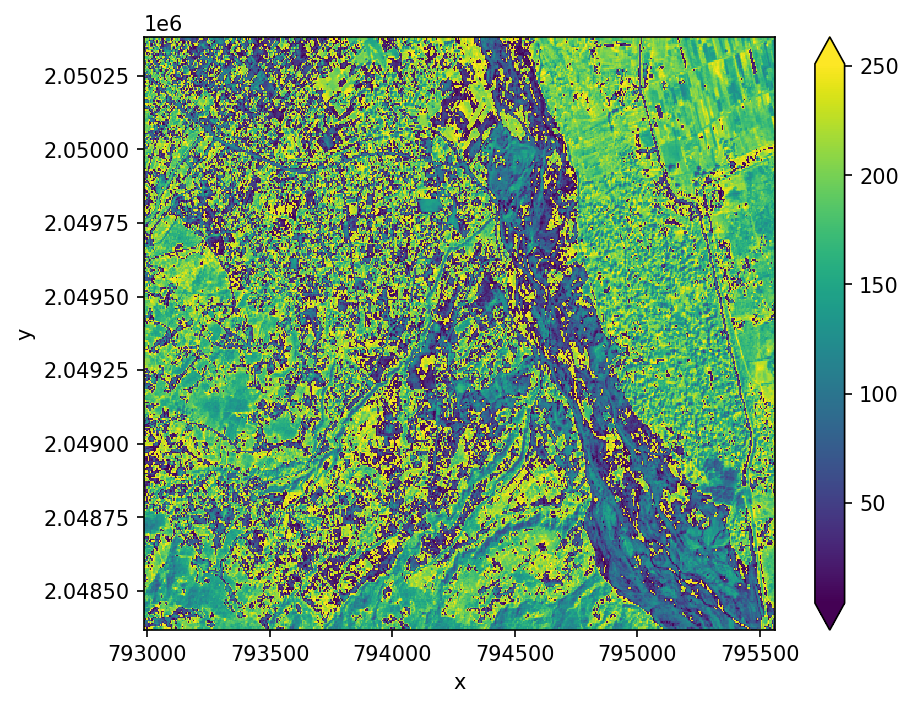

In [2]:
fig, ax = plt.subplots(dpi=150)

with gw.open(rgbn, band_names=['red','green','blue','nir']) as ds:
    add_nir_red = ds.sel(band='nir') + ds.sel(band='red')
    add_nir_red.plot(robust=True, ax=ax)
    print(add_nir_red)
plt.tight_layout(pad=1)

These simple operations can be combined with other geowombat functions to create more complex outputs like vegetation indices described below.

## Vegetation indices
Healthy vegetation (with chlorophyll) reflects more near-infrared (NIR) and green light compared to other wavelengths and absorbs more red and blue light. We can use this effect to generate a number of vegetation indices including the following:


### Enhanced Vegetation Index (EVI)
EVI is an index of vegetation that is optimized to improve sensitivity to high biomass and better handling of background and atmospheric influences. It is calculated with the formula below using the Near Infrared (NIR), Red and Blue bands. There are also a number of parameters like $C_{1}$ that are specific to each sensor. Luckily geowombat handles this all for you! 

$$EVI = G\times \frac{NIR-Red}{NIR+C_{1}\times Red-C_{2}\times Blue+L}$$

The result of this formula generates a value between -1 and +1.  Low reflectance (low values) in the red channel and high reflectance in the NIR channel will yield a high EVI value.

Let's start by looking at the original image in true color.

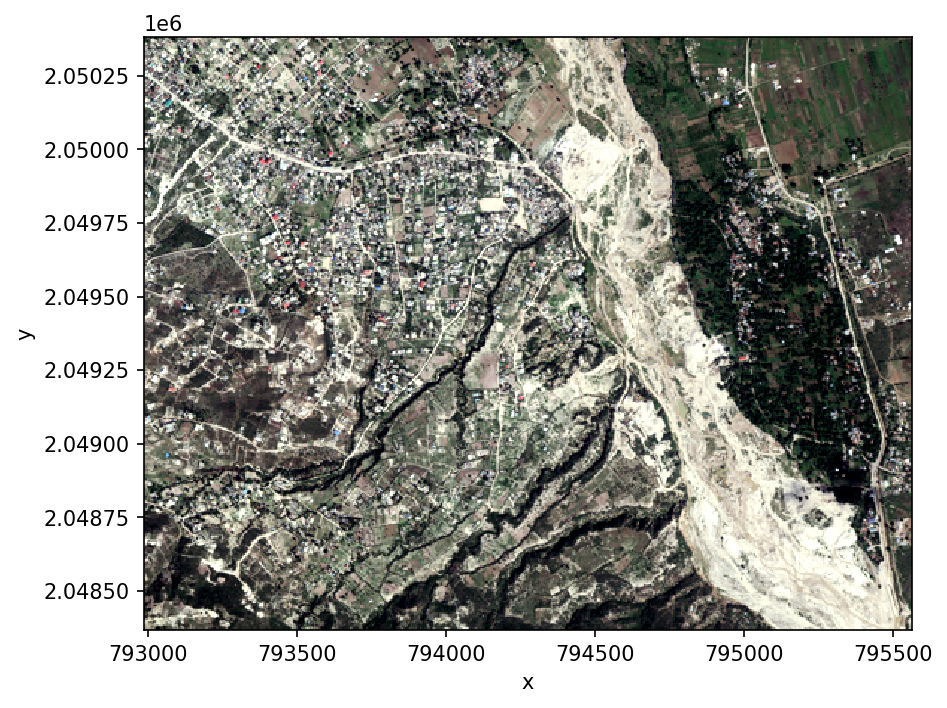

In [3]:
import geowombat as gw
from geowombat.data import rgbn
import matplotlib.pyplot as plt


fig, ax = plt.subplots(dpi=150)

with gw.config.update(sensor='rgbn', scale_factor=0.0001):
    with gw.open(rgbn) as ds:
        ds.sel(band=['blue', 'green', 'red']).plot.imshow(robust=True)
plt.tight_layout(pad=1)

Calculate a vegetation index, returning an `Xarray.DataArray`.

In [4]:
with gw.open(rgbn) as ds:
    print(ds)
    evi = ds.gw.evi(sensor='rgbn', scale_factor=0.0001)
    print(evi)

<xarray.DataArray (band: 4, y: 403, x: 515)>
dask.array<open_rasterio-e6027924f902ae2b465f7c581474bbb2<this-array>, shape=(4, 403, 515), dtype=uint8, chunksize=(4, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3 4
  * x        (x) float64 7.93e+05 7.93e+05 7.93e+05 ... 7.956e+05 7.956e+05
  * y        (y) float64 2.05e+06 2.05e+06 2.05e+06 ... 2.048e+06 2.048e+06
Attributes: (12/14)
    transform:           (5.0, 0.0, 792988.0, 0.0, -5.0, 2050382.0)
    crs:                 32618
    res:                 (5.0, 5.0)
    is_tiled:            1
    nodatavals:          (nan, nan, nan, nan)
    _FillValue:          nan
    ...                  ...
    AREA_OR_POINT:       Area
    DataType:            Generic
    filename:            /home/mmann1123/miniconda3/envs/pygis2/lib/python3.1...
    resampling:          nearest
    _data_are_separate:  0
    _data_are_stacked:   0
<xarray.DataArray (band: 1, y: 403, x: 515)>
dask.array<where, shape=(1, 403, 515), dt

Or use the configuration context to set parameters.

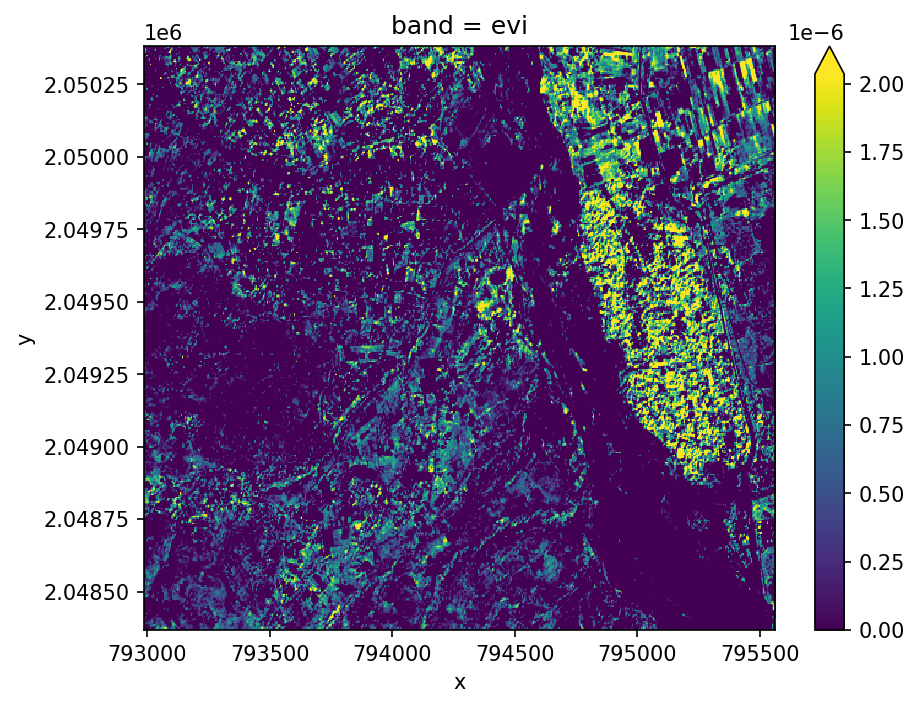

In [5]:
fig, ax = plt.subplots(dpi=150)

with gw.config.update(sensor='rgbn', scale_factor=0.0001):
    with gw.open(rgbn) as ds:
        ds.sel(band=['blue', 'green', 'red']).plot.imshow(robust=True)
        evi = ds.gw.evi()
        evi.plot(robust=True)
plt.tight_layout(pad=1)

### Two-band Enhanced Vegetation Index (EVI2)
We can also calcuate an approximation of EVI with two bands using $G\times ((NIR-RED)/(L+NIR+C\times Red))$

This allows us to extend EVI calculations back in time using AVHRR, and avoids some problems with the blue band which tends to be noisy.

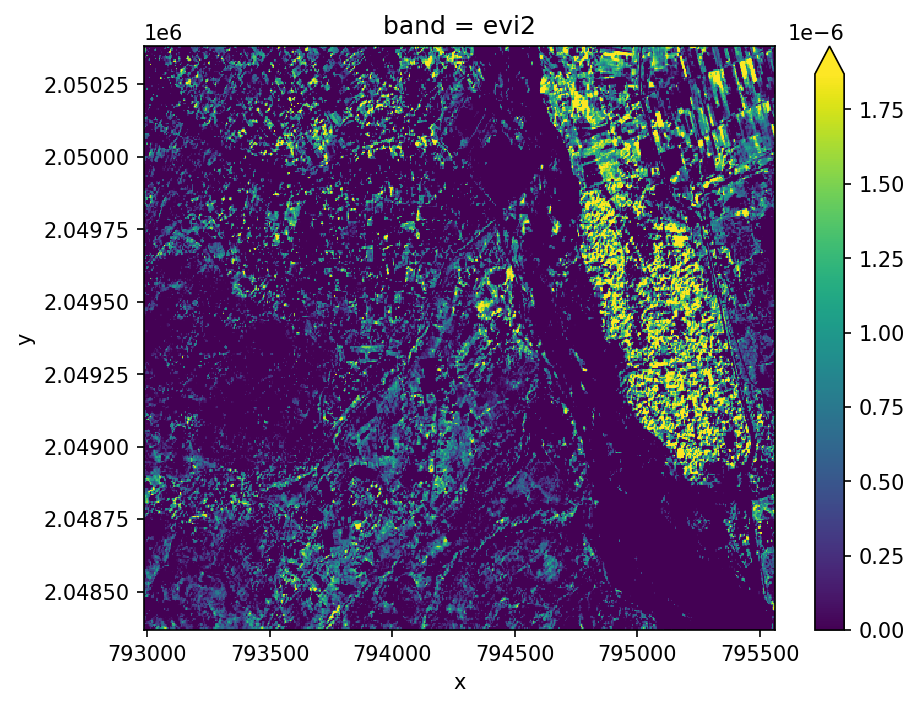

In [6]:
fig, ax = plt.subplots(dpi=150)

with gw.config.update(sensor='rgbn', scale_factor=0.0001):
    with gw.open(rgbn) as ds:
        evi2 = ds.gw.evi2()
        evi2.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

### Normalized Difference Indices (NDVI)
The simplest vegetation metric is NDVI, which is just the normalized difference between the Red and NIR bands. It is calculated as follows $\frac{NIR-Red}{NIR+Red}$.

We can calculate it using the generic `norm_diff` function for any two-band combination.

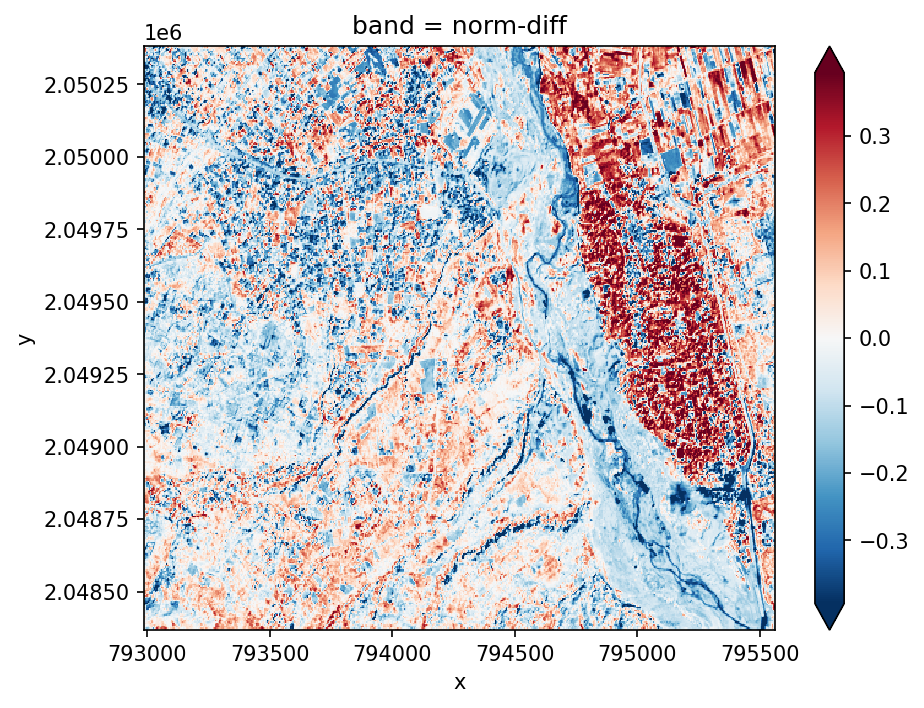

In [7]:
fig, ax = plt.subplots(dpi=150)

with gw.config.update(sensor='rgbn'):
    with gw.open(rgbn) as ds:
        ndvi = ds.gw.norm_diff('red', 'nir')
        ndvi.plot(robust=True)
plt.tight_layout(pad=1)

### Tasseled Cap Transformations
Tasseled cap tranform uses a linear equation to try to differentiate different components of the spectrum that are of interest for vegetation dynamics such as phenological stages. The output includes three bands including `brightness`, `greeness` for vegetation, and `wetness` as an idicator of soil and canopy moisture. Use `.sel(band='wetness')` to select them individually.

bands ['brightness' 'greenness' 'wetness']


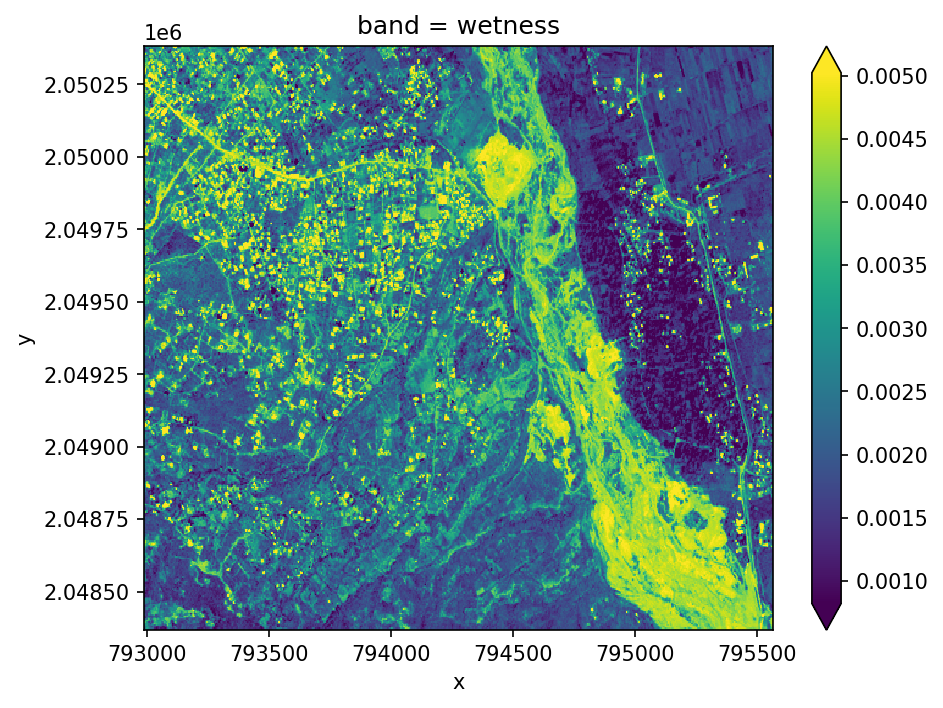

In [8]:
fig, ax = plt.subplots(dpi=150)

with gw.config.update(sensor='qb', scale_factor=0.0001):
    with gw.open(rgbn) as ds:
        tcap = ds.gw.tasseled_cap()
        print('bands', tcap.band.values)
        tcap.sel(band='wetness').plot(robust=True, ax=ax)
plt.tight_layout(pad=1)


## Learn More

For additional details, understanding, and in-depth explanations, consider exploring the following online resources:

- [Good list of Vegetation Index References](https://en.wikipedia.org/wiki/Vegetation_index)
- [Enhanced Vegetation Index (EVI)](https://en.wikipedia.org/wiki/Enhanced_vegetation_index)
- [Tasseled Cap Transformation](https://en.wikipedia.org/wiki/Tasseled_cap_transformation)
- [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)